# Let's Hack on some TESS Light Curves

Shiny new data! Woo!

In [1]:
%matplotlib notebook

import os
os.environ["MKL_NUM_THREADS"] = "4"

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')
sns.set_context('talk')

import numpy as np
import pandas as pd

import astropy.io.fits as fits

In [2]:
datadir = "/data/epyc/data/tess/"

Let's look at a single file:

In [3]:
import glob

In [4]:
datafiles = glob.glob(datadir+"**/*.fits", recursive=True)

In [5]:
len(datafiles)

24758

Let's make a dictionary with the information about where files are, what sector they're in, and what the cadence is etc:

In [6]:
tess_info = []

# loop over all data files
for f in datafiles:
    # make an empty dictionary for the information
    single_info = {}
    
    # split the path into folders
    fsplit = f.split("/")
    # get out the sub-directory with the file
    single_info["subdir"] = fsplit[-2]
    
    # get the filename
    single_info["filename"] = fsplit[-1]
    
    # split the filename
    fname_split = single_info["filename"].split("-")
    
    # split out information in the filename
    single_info["daterange"] = fname_split[0]
    single_info["sector_no"] = fname_split[1]
    single_info["tess_id"] = fname_split[2]
    single_info["cadence"] = fname_split[3]
    
    # append to list
    tess_info.append(single_info)
    

In [7]:
tess_info = pd.DataFrame(tess_info)

In [8]:
tess_info.head()

,cadence,daterange,filename,sector_no,subdir,tess_id
0,0120,tess2018206045859,tess2018206045859-s0001-0000000024704388-0120-...,s0001,sector001,0000000024704388
1,0120,tess2018206045859,tess2018206045859-s0001-0000000008195886-0120-...,s0001,sector001,0000000008195886
2,0120,tess2018206045859,tess2018206045859-s0001-0000000024703650-0120-...,s0001,sector001,0000000024703650
3,0120,tess2018206045859,tess2018206045859-s0001-0000000008196058-0120-...,s0001,sector001,0000000008196058
4,0120,tess2018206045859,tess2018206045859-s0001-0000000024704862-0120-...,s0001,sector001,0000000024704862


In [9]:
np.min(tess_info["tess_id"])

'0000000002733208'

In [10]:
np.max(tess_info["tess_id"])

'0000000325469754'

Let's make a function for that:

In [11]:
def read_tess_info(datadir):
    """
    Traverse the directory structure of TESS light curve 
    files and get out some useful information, like 
    the TESS object ID, the subdirectory, file name 
    and cadence.
    
    Parameters
    ----------
    datadir: str
        The path to the top level directory where the 
        TESS data is located.
        
    Returns
    -------
    tess_info : pd.DataFrame
        A DataFrame with some useful information about the 
        TESS light curves.
        Columns:
            * subdir: the sub-directory where the file is located
            * filename: the actual file name of the data file
            * daterange: the date range of the data, taken from the file name
            * sector_no : the sector number, taken from the file name
            * tess_id: the Tess Object Identifier, taken from the file name
            * cadence: the cadence of the light curve, taken from the file name
    """
    # glob all the data files
    datafiles = glob.glob(datadir+"**/*.fits", recursive=True)
    
    tess_info = []

    # loop over all data files
    for f in datafiles:
        # make an empty dictionary for the information
        single_info = {}

        # split the path into folders
        fsplit = f.split("/")
        # get out the sub-directory with the file
        single_info["subdir"] = fsplit[-2]

        # get the filename
        single_info["filename"] = fsplit[-1]

        # split the filename
        fname_split = single_info["filename"].split("-")

        # split out information in the filename
        single_info["daterange"] = fname_split[0]
        single_info["sector_no"] = fname_split[1]
        single_info["tess_id"] = np.int(fname_split[2])
        single_info["cadence"] = fname_split[3]

        # append to list
        tess_info.append(single_info)
        
    # make a data frame
    tess_info = pd.DataFrame(tess_info)

    return tess_info

In [12]:
tess_info = read_tess_info(datadir)

In [13]:
tess_info.head()

,cadence,daterange,filename,sector_no,subdir,tess_id
0,0120,tess2018206045859,tess2018206045859-s0001-0000000024704388-0120-...,s0001,sector001,24704388
1,0120,tess2018206045859,tess2018206045859-s0001-0000000008195886-0120-...,s0001,sector001,8195886
2,0120,tess2018206045859,tess2018206045859-s0001-0000000024703650-0120-...,s0001,sector001,24703650
3,0120,tess2018206045859,tess2018206045859-s0001-0000000008196058-0120-...,s0001,sector001,8196058
4,0120,tess2018206045859,tess2018206045859-s0001-0000000024704862-0120-...,s0001,sector001,24704862


In [14]:
len(tess_info)

24824

### Adding GAIA Information
Let's also read in the GAIA cross-match information:

In [15]:
gaiamatch1 = pd.read_csv(datadir+"gaiatess1_xmatch-result.csv")
gaiamatch2 = pd.read_csv(datadir+"gaiatess2_xmatch-result.csv")

In [16]:
gaiamatch = pd.concat([gaiamatch1, gaiamatch2], ignore_index=True, sort=True)

In [17]:
tess_gaia = pd.merge(tess_info, gaiamatch, left_on="tess_id", right_on="ticid")

In [18]:
tess_gaia.columns

Index(['cadence', 'daterange', 'filename', 'sector_no', 'subdir', 'tess_id',
       'a_g_percentile_lower', 'a_g_percentile_upper', 'a_g_val',
       'astrometric_chi2_al',
       ...
       'solution_id', 'source_id', 'teff_percentile_lower',
       'teff_percentile_upper', 'teff_val', 'tess_sector1_oid',
       'tess_sector2_oid', 'ticid', 'tmag', 'visibility_periods_used'],
      dtype='object', length=111)

### Reading a single file

Let's read in a single file and see what it looks like:

In [19]:
o1 = tess_info.loc[0]

In [20]:
f1 = o1["filename"]
d1 = o1["subdir"]

In [21]:
o1 = tess_info.loc[0]
f1 = o1["filename"]
d1 = o1["subdir"]
fname = datadir + d1 + "/" + f1

In [22]:
fname

'/data/epyc/data/tess/sector001/tess2018206045859-s0001-0000000024704388-0120-s_lc.fits'

In [23]:
hdulist = fits.open(fname)

In [24]:
hdulist[0].header

SIMPLE  =                    T / conforms to FITS standards                     
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T / file contains extensions                       
NEXTEND =                    2 / number of standard extensions                  
EXTNAME = 'PRIMARY '           / name of extension                              
EXTVER  =                    1 / extension version number (not format version)  
SIMDATA =                    F / file is based on simulated data                
ORIGIN  = 'NASA/Ames'          / institution responsible for creating this file 
DATE    = '2018-09-27'         / file creation date.                            
TSTART  =    1325.293656167129 / observation start time in TJD                  
TSTOP   =    1353.176978345185 / observation stop time in TJD                   
DATE-OBS= '2018-07-25T19:01:

In [25]:
# get out some header information
tstart = hdulist[0].header["TSTART"]
tstop = hdulist[0].header["TSTOP"]
date_obs = hdulist[0].header["DATE-OBS"]
date_end = hdulist[0].header["DATE-END"]
ticid = hdulist[0].header["TICID"]
ra = hdulist[0].header["RA_OBJ"]
dec = hdulist[0].header["DEC_OBJ"]
pmra = hdulist[0].header["PMRA"]
pmdec = hdulist[0].header["PMDEC"]
pmtotal = hdulist[0].header["PMTOTAL"]
tessmag = hdulist[0].header["TESSMAG"]
teff = hdulist[0].header["TEFF"]
log_g = hdulist[0].header["LOGG"]
mh = hdulist[0].header["MH"]
radius = hdulist[0].header["RADIUS"]

In [26]:
hdulist[1].data

FITS_rec([(1325.29650043, 0.00214334, 70444, 44876.914, 23.26281 , 1309.0525, 4.108585 ,       nan,       nan, 8, 452.30152379, 0.00037456, 1915.5476808 , 0.00032565, 452.43893897, 0.0003935 , 1915.51281525, 0.00036768,         nan,         nan),
          (1325.29788934, 0.00214335, 70445, 44975.3  , 23.288473, 1311.6859, 4.115023 , 49988.17 , 25.968716, 0, 452.36848812, 0.00034122, 1915.61783752, 0.00033311, 452.49680178, 0.00039348, 1915.57455871, 0.00036616, -0.05648563, -0.00542627),
          (1325.29927824, 0.00214337, 70446, 44926.195, 23.276829, 1312.5608, 4.1148467, 49939.836, 25.955729, 0, 452.39763967, 0.00033948, 1915.65292907, 0.00033161, 452.52466627, 0.00039408, 1915.60529694, 0.00036563, -0.02572887,  0.02857318),
          ...,
          (1353.1757761 , 0.0022635 , 90517, 44970.02 , 23.299223, 1345.5966, 4.1438465, 49957.04 , 25.980703, 0, 452.42926301, 0.00033383, 1915.56236444, 0.00032479, 452.55170831, 0.00039389, 1915.52461486, 0.00036869,  0.00780932, -0.05915216

In [27]:
time = hdulist[1].data.field("TIME")
flux = hdulist[1].data.field("PDCSAP_FLUX")
flux_err = hdulist[1].data.field("PDCSAP_FLUX_ERR")
quality = hdulist[1].data.field("QUALITY")

In [28]:
hdulist.close()

I want to look at the quality factors:

In [29]:
np.min(quality)

0

In [30]:
np.max(quality)

512

In [31]:
mask = (quality == 0)

In [32]:
mask = (quality == 0)
time = time[mask]
flux = flux[mask]
flux_err = flux_err[mask]

<IPython.core.display.Javascript object>


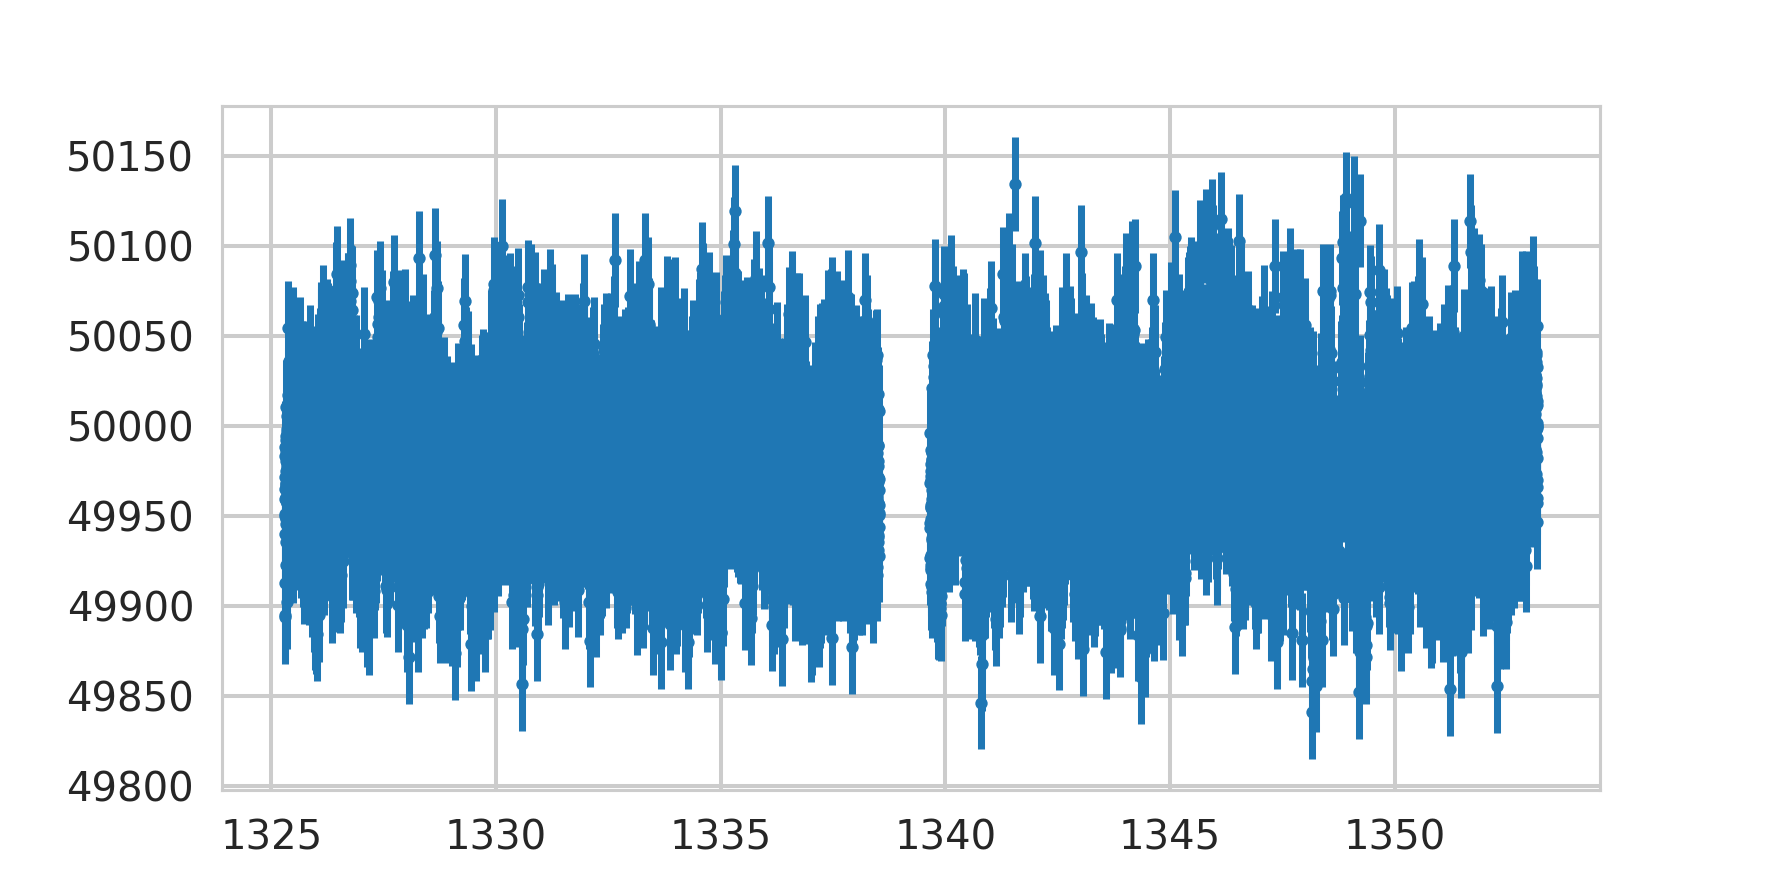

<ErrorbarContainer object of 3 artists>

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(8,4))
ax.errorbar(time, flux, yerr=flux_err, fmt="o", markersize=4)

In [35]:
def read_tess_lightcurve(filename, pdc=True, quality_flag=0):
    """
    Read out a TESS light curve out of a light curve file.
    
    Parameters
    ----------
    filename : str
        The path and file name of the FITS file to be read
        
    pdc : bool, default True
        If True, use the Pre-search Data Conditioning (PDC)
        corrected light curve (`PDCSAP_FLUX`). If False, 
        then read out the uncorrected light curves (`SAP_FLUX`).
        Note: the uncorrected light curves have lots of instrumental
        effects, but the corrected ones might have smoothed out 
        some periodic structure.
        
    quality_flag, int, default 0
        The quality flag to denote "good" data, default is 0
    """
    hdulist = fits.open(fname)
    # get out some header information
    
    data = {}
    data["tstart"] = hdulist[0].header["TSTART"]
    data["tstop"] = hdulist[0].header["TSTOP"]
    data["date_obs"] = hdulist[0].header["DATE-OBS"]
    data["date_end"] = hdulist[0].header["DATE-END"]
    data["ticid"] = hdulist[0].header["TICID"]
    data["ra"] = hdulist[0].header["RA_OBJ"]
    data["dec"] = hdulist[0].header["DEC_OBJ"]
    data["pmra"] = hdulist[0].header["PMRA"]
    data["pmdec"] = hdulist[0].header["PMDEC"]
    data["pmtotal"] = hdulist[0].header["PMTOTAL"]
    data["tessmag"] = hdulist[0].header["TESSMAG"]
    data["teff"] = hdulist[0].header["TEFF"]
    data["log_g"] = hdulist[0].header["LOGG"]
    data["mh"] = hdulist[0].header["MH"]
    data["radius"] = hdulist[0].header["RADIUS"]
    
    # set the correct key for reading out the flux
    flux_key = "SAP_FLUX"
    flux_err_key = "SAP_FLUX_ERR"

    if pdc:
        flux_key = "PDC%s"%flux_key
        flux_err_key = "PDC%s"%flux_err_key
        
    # read out the actual data
    # note: first data point in flux and flux_err seems 
    # to be NaN, so I'm going to exclude it:
    time = hdulist[1].data.field("TIME")[1:]
    flux = hdulist[1].data.field("PDCSAP_FLUX")[1:]
    flux_err = hdulist[1].data.field("PDCSAP_FLUX_ERR")[1:]
    quality = hdulist[1].data.field("QUALITY")[1:]
    hdulist.close()
    
    # get out good quality data and point that are 
    # not NaN or inf
    mask = (quality == quality_flag) & (np.isfinite(flux))
    
    data["time"] = time[mask]
    data["flux"] = flux[mask]
    data["flux_err"] = flux_err[mask]
    return data

Let's try it!

In [36]:
test_lc = read_tess_lightcurve(fname, pdc=True)

In [37]:
test_lc

{'tstart': 1325.293656167129,
 'tstop': 1353.176978345185,
 'date_obs': '2018-07-25T19:01:42.709Z',
 'date_end': '2018-08-22T16:13:41.745Z',
 'ticid': 24704388,
 'ra': 25.564858,
 'dec': -69.759223,
 'pmra': 24.9725,
 'pmdec': -24.2341,
 'pmtotal': 34.79823787,
 'tessmag': 8.70400047,
 'teff': 4691.25,
 'log_g': 2.70546007,
 'mh': -0.27000001,
 'radius': 8.21191978,
 'time': array([1325.29788934, 1325.29927824, 1325.30066715, ..., 1353.1757761 ,
        1353.17716498, 1353.17855386]),
 'flux': array([49988.17 , 49939.836, 49893.703, ..., 49957.04 , 50032.67 ,
        49993.523], dtype=float32),
 'flux_err': array([25.968716, 25.955729, 25.949875, ..., 25.980703, 25.999208,
        25.990774], dtype=float32)}

I need some extra columns in my info table:

Okay, cool. I want to extract some features from cesium, I think:

In [39]:
from cesium import featurize

In [40]:
features_to_use = [#"amplitude",
                   #"percent_beyond_1_std",
                   #"maximum",
                   #"max_slope",
                   "median",
                   #"median_absolute_deviation",
                   #"minimum",
                   #"skew",
                   "std",
                   "stetson_j", "stetson_k"]

In [42]:
%%time 
fset_cesium = featurize.featurize_time_series(times=time,
                                              values=flux,
                                              errors=flux_err,
                                              features_to_use=features_to_use)

/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/cesium/features/amplitude.py:51: RuntimeWarning: invalid value encountered in double_scalars
  return (y_high - y_low) / (y_95 - y_5)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/cesium/features/amplitude.py:22: RuntimeWarning: invalid value encountered in double_scalars
  return max(abs((y_max - y_med) / y_med), abs((y_med - y_min) / y_med))
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/cesium/features/amplitude.py:37: RuntimeWarning: invalid value encountered in double_scalars
  return (y_95 - y_5) / y_50
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/cesium/features/cadence_features.py:12: RuntimeWarning: divide by zero encountered in true_divide
  return (cads[2:] + cads[:-2]) / (cads[1:-1] - cads[:-2])
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/numpy/core/_methods.py:112: RuntimeWarning: invalid value encountered i

CPU times: user 2min 13s, sys: 2min 30s, total: 4min 43s
Wall time: 1min 44s


In [43]:
print(fset_cesium)

feature        median        std   stetson_j stetson_k
channel             0          0           0         0
0        49979.707031  34.621352  274.931493  0.995004


Let's now loop over all data files we currently have and calculate some variability info:

In [46]:
tess_info["mean_flux"] = np.zeros(len(tess_info))
tess_info["median_flux"] = np.zeros(len(tess_info))
tess_info["var_flux"] = np.zeros(len(tess_info))
tess_info["rms_flux"] = np.zeros(len(tess_info))
tess_info["max_flux"] = np.zeros(len(tess_info))

tess_info["ra"] = np.zeros(len(tess_info))
tess_info["dec"] = np.zeros(len(tess_info))
tess_info["tessmag"] =np.zeros(len(tess_info))
tess_info["teff"] = np.zeros(len(tess_info))
tess_info["log_g"] = np.zeros(len(tess_info))
tess_info["mh"] = np.zeros(len(tess_info))
tess_info["radius"] = np.zeros(len(tess_info))

In [ ]:
lc_all = []

# loop over all light curves
for idx in tess_info.index:
    print(idx)
    # get out the row from the DataFrame
    o1 = tess_info.loc[idx]
    
    # get out the file name and subdirectory with the data
    f1 = o1["filename"]
    d1 = o1["subdir"]
    fname = datadir + d1 + "/" + f1
    
    try:
        # read out the light curve and anxilliary data
        lc = read_tess_lightcurve(fname, pdc=True)

        lc_all.append(lc)

        # get out time and flux
        time = lc["time"]
        flux = lc["flux"]
        
        tess_info.loc[idx, "ra"] = lc["ra"]
        tess_info.loc[idx, "dec"] = lc["dec"]
        tess_info.loc[idx, "tessmag"] = lc["tessmag"]
        tess_info.loc[idx, "teff"] = lc["teff"]
        tess_info.loc[idx, "log_g"] = lc["log_g"]
        tess_info.loc[idx, "mh"] = lc["mh"]
        tess_info.loc[idx, "radius"] = lc["radius"]

        mean_flux = np.nanmean(flux)
        var_flux = np.nanvar(flux)
        median_flux = np.nanmedian(flux)
        rms_flux = 0.7413*(np.nanpercentile(flux, 75)-np.nanpercentile(flux, 25))
        max_flux = np.nanmax(flux)

        #print("mean_flux: " + str(mean_flux))
        #print("var_flux: " + str(var_flux))
        tess_info.loc[idx, "mean_flux"] = mean_flux
        tess_info.loc[idx, "median_flux"] = median_flux
        tess_info.loc[idx, "var_flux"] = var_flux
        tess_info.loc[idx, "rms_flux"] = rms_flux
        tess_info.loc[idx, "max_flux"] = max_flux

    except OSError:
        continue

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962


In [48]:
tess_info.head()

,cadence,daterange,filename,sector_no,subdir,tess_id,mean_flux,median_flux,var_flux,rms_flux,ra,dec,tessmag,teff,log_g,mh,radius,max_flux
0,0120,tess2018206045859,tess2018206045859-s0001-0000000024704388-0120-...,s0001,sector001,24704388,49980.242188,49979.707031,1198.638062,34.233002,25.564858,-69.759223,8.704,4691.25,2.70546,-0.27,8.21192,50134.468750
1,0120,tess2018206045859,tess2018206045859-s0001-0000000008195886-0120-...,s0001,sector001,8195886,18629.839844,18619.855469,2270.682373,47.250636,311.332559,-38.427576,9.852,5704.00,4.34502,<astropy.io.fits.card.Undefined object at 0x7f...,1.12254,18794.021484
2,0120,tess2018206045859,tess2018206045859-s0001-0000000024703650-0120-...,s0001,sector001,24703650,12390.344727,12390.205078,206.094437,14.232743,25.103309,-71.522476,10.253,5520.00,4.41713,<astropy.io.fits.card.Undefined object at 0x7f...,1.00923,12452.214844
3,0120,tess2018206045859,tess2018206045859-s0001-0000000008196058-0120-...,s0001,sector001,8196058,81576.226562,81577.304688,10696.076172,101.102027,311.368862,-38.065450,8.180,4562.00,<astropy.io.fits.card.Undefined object at 0x7f...,<astropy.io.fits.card.Undefined object at 0x7f...,0.748564,81950.750000
4,0120,tess2018206045859,tess2018206045859-s0001-0000000024704862-0120-...,s0001,sector001,24704862,126575.453125,126574.539062,1719.606079,40.331353,25.311127,-67.676964,7.734,5809.00,4.09217,<astropy.io.fits.card.Undefined object at 0x7f...,1.52249,126787.039062


Let's save this to file before I do anything else:

In [49]:
tess_info.to_csv(datadir+"tess_info.csv")

Let's look at the variability measures:

<IPython.core.display.Javascript object>


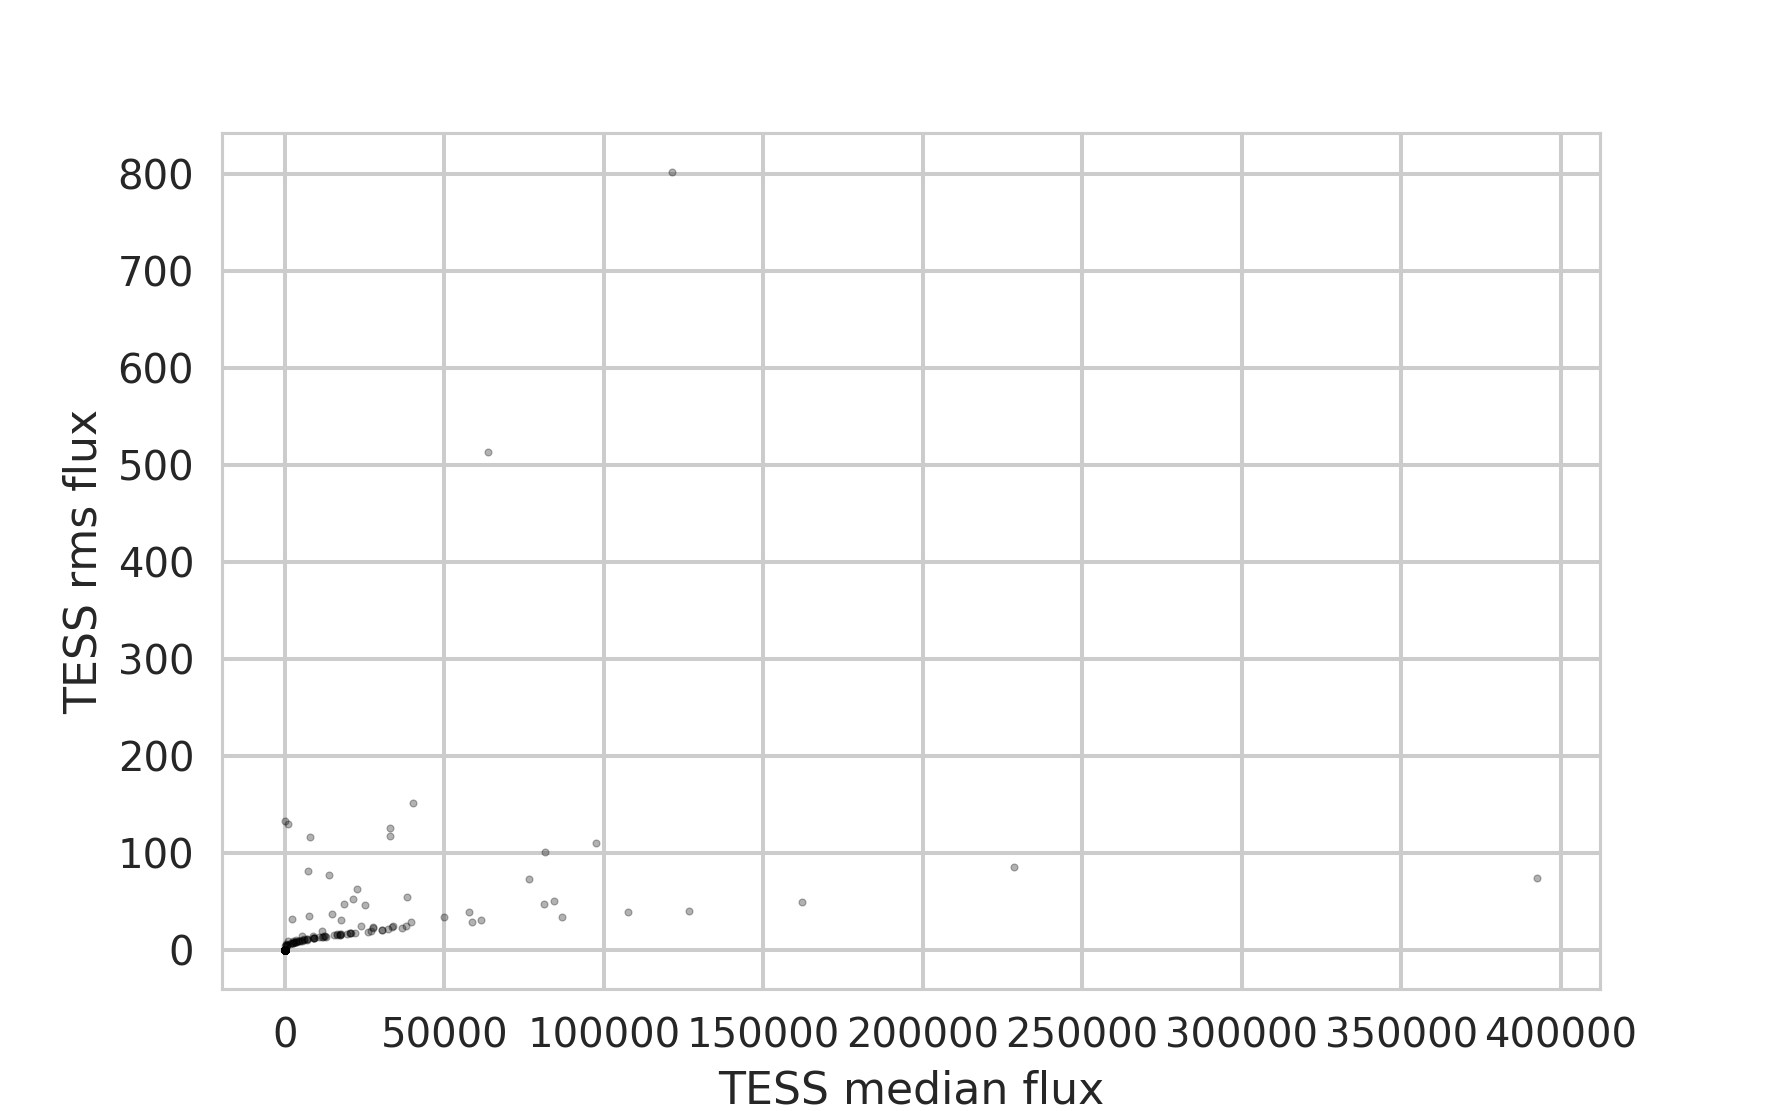

Text(0,0.5,'TESS rms flux')

In [50]:
fig, ax = plt.subplots(1, 1, figsize=(8,5))

ax.scatter(tess_info["median_flux"], tess_info["rms_flux"], s=5, c='black', alpha=0.3)
ax.set_xlabel("TESS median flux")
ax.set_ylabel("TESS rms flux")
#ax.set_xscale("log")

#plt.tight_layout()

Okay, let's look at everything that has (rms > 30):

In [65]:
variable = tess_info[tess_info["rms_flux"] >= 30]